## 1. Introduction

This notebook implements **Part 2: Analysis and Modeling** of the DAT204M HW2 project.

It connects directly to the Supabase cloud database created in Part 1, retrieves data, and performs:
- Exploratory Data Analysis (EDA)
- Data visualization
- Simple Machine Learning modeling (Track A)

The objective is to build a predictive model that estimates **CO₂ emissions per capita** using energy, economic, and demographic indicators.

This workflow highlights the end-to-end integration of cloud data persistence and data-driven analysis.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
from supabase import create_client

load_dotenv()

url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")

supabase = create_client(url, key)

In [21]:
TABLE_NAME = "brn_indicators"

# Target and candidate features for Track A
TARGET = "co2_per_capita_tco2e_excl_lulucf"
FEATURES = [
    "energy_use_kg_oe_per_capita",
    "gdp_current_usd",
    "population_total",
    "urban_pop_pct",
    "renewable_energy_consumption_pct",
]

# Optional filters if you want a specific country or year range
FILTER_COUNTRY = None            # e.g., "BRN" or None for all available
YEAR_MIN, YEAR_MAX = None, None  # e.g., 1990, 2022 or None

## 2. Data Retrieval from Supabase

We query the same `brn_indicators` table uploaded in Part 1.

Instead of reading from a local CSV, this notebook retrieves data directly from Supabase using the REST API (`supabase-py` client).

This demonstrates:
- Cloud-based reproducibility.
- Separation between data storage and analysis environments.
- Ability to re-run analysis from any machine with credentials.

In [22]:
# Build the query
q = supabase.table(TABLE_NAME).select("*")

if FILTER_COUNTRY:
    q = q.eq("country", FILTER_COUNTRY)
if YEAR_MIN is not None:
    q = q.gte("year", YEAR_MIN)
if YEAR_MAX is not None:
    q = q.lte("year", YEAR_MAX)

resp = q.execute()
df = pd.DataFrame(resp.data)

print(df.shape)
df.sort_values(["country", "year"]).head()

(350, 11)


,country,year,co2_per_capita_tco2e_excl_lulucf,co2_total_mtco2e_excl_lulucf,energy_use_kg_oe_per_capita,gdp_current_usd,population_total,renewable_electricity_pct,renewable_energy_consumption_pct,urban_pop_pct,missing_indicator_count
0,BRN,1990,16.843458,4.3000,6766.202658,6.039881e+09,255292,0.0,0.7,66.438,0
1,BRN,1991,18.696020,4.9095,7438.262038,6.284497e+09,262596,0.0,0.4,66.585,0
2,BRN,1992,19.868514,5.3613,7783.232736,6.327966e+09,269839,0.0,0.2,67.078,0
3,BRN,1993,19.535619,5.4108,7299.532663,6.203340e+09,276971,0.0,0.0,67.604,0
4,BRN,1994,19.338170,5.4938,6603.066579,6.467783e+09,284091,0.0,0.0,68.126,0


In [23]:
required_cols = ["country", "year", TARGET] + FEATURES
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing columns in table: {missing}"

# Ensure correct types
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
for col in FEATURES + [TARGET]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep rows that have the target
df = df.dropna(subset=[TARGET]).copy()

# Brief info
display(df[["country", "year", TARGET] + FEATURES].head())
print(df[["country", "year"]].drop_duplicates().shape[0], "country-year rows")

,country,year,co2_per_capita_tco2e_excl_lulucf,energy_use_kg_oe_per_capita,gdp_current_usd,population_total,urban_pop_pct,renewable_energy_consumption_pct
0,BRN,1990,16.843458,6766.202658,6.039881e+09,255292,66.438,0.7
1,BRN,1991,18.696020,7438.262038,6.284497e+09,262596,66.585,0.4
2,BRN,1992,19.868514,7783.232736,6.327966e+09,269839,67.078,0.2
3,BRN,1993,19.535619,7299.532663,6.203340e+09,276971,67.604,0.0
4,BRN,1994,19.338170,6603.066579,6.467783e+09,284091,68.126,0.0


350 country-year rows


In [24]:
display(df[[TARGET] + FEATURES].describe().T)

missing_counts = df[[TARGET] + FEATURES].isna().sum().sort_values(ascending=False)
print("Missing values:\n", missing_counts)

,count,mean,std,min,25%,50%,75%,max
co2_per_capita_tco2e_excl_lulucf,350.0,4.545977e+00,5.901219e+00,5.861892e-02,6.164060e-01,1.796210e+00,7.090627e+00,2.362537e+01
energy_use_kg_oe_per_capita,350.0,1.987937e+03,2.500569e+03,2.588368e+02,4.077525e+02,6.723931e+02,2.507310e+03,9.699300e+03
gdp_current_usd,350.0,1.709432e+11,2.385773e+11,8.655599e+08,1.344133e+10,7.896367e+10,2.570312e+11,1.396300e+12
population_total,350.0,5.764443e+07,6.861710e+07,2.552920e+05,6.079419e+06,3.768746e+07,7.566818e+07,2.834879e+08
urban_pop_pct,315.0,4.208195e+01,1.840725e+01,1.543700e+01,2.733600e+01,3.805200e+01,5.299900e+01,7.943900e+01
renewable_energy_consumption_pct,350.0,3.618514e+01,2.963801e+01,0.000000e+00,4.425000e+00,3.210000e+01,6.025000e+01,9.110000e+01


Missing values:
 urban_pop_pct                       35
co2_per_capita_tco2e_excl_lulucf     0
energy_use_kg_oe_per_capita          0
gdp_current_usd                      0
population_total                     0
renewable_energy_consumption_pct     0
dtype: int64


## 3. Exploratory Data Analysis (EDA)

EDA helps us understand relationships among key variables such as:
- CO₂ emissions per capita
- Energy consumption per capita
- GDP (current USD)
- Urban population percentage
- Renewable energy share

We use `pandas`, `matplotlib`, and `seaborn` to:
- Summarize basic statistics.
- Plot distributions and time series.
- Visualize correlations among features.

This step helps guide feature selection and verify data consistency.

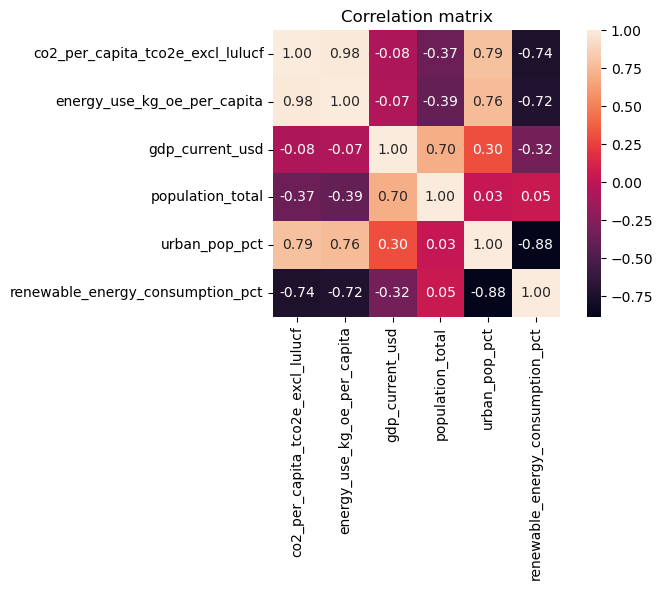

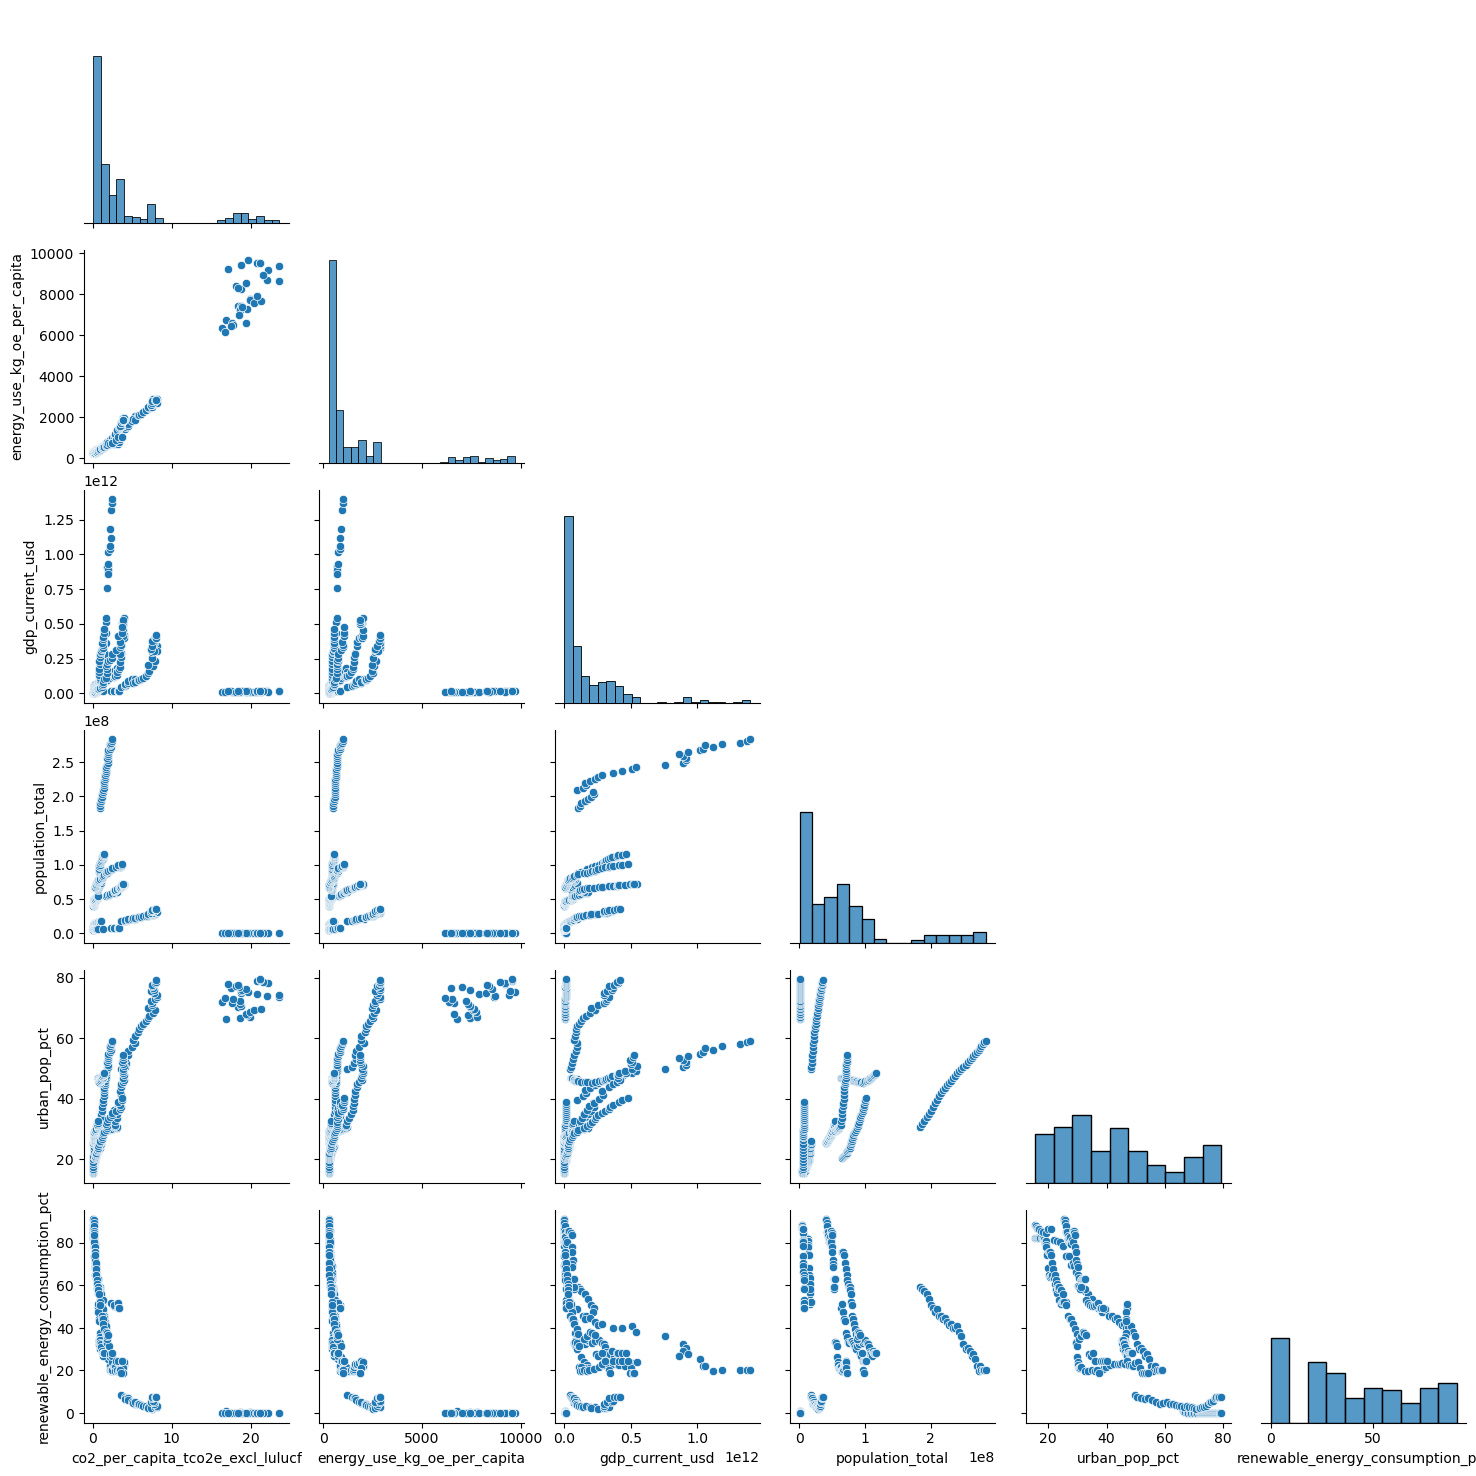

In [25]:
num_cols = [TARGET] + [c for c in FEATURES if c in df.columns]
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

# Pairplot can be slow on very large data; safe for your dataset sizes
sns.pairplot(df[num_cols].dropna(), corner=True, diag_kind="hist")
plt.show()

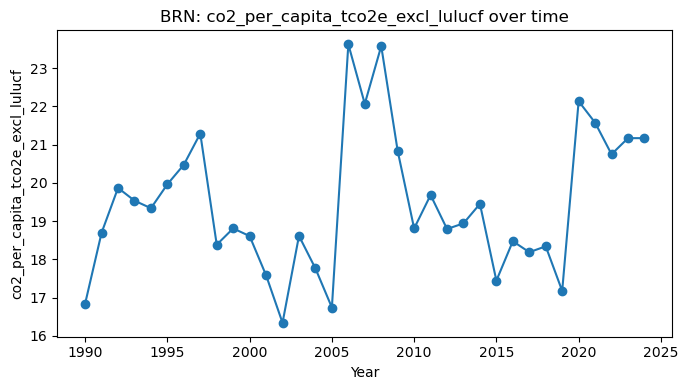

In [26]:
if "country" in df.columns:
    sample_country = FILTER_COUNTRY or df["country"].value_counts().index[0]
    ts = df[df["country"] == sample_country].sort_values("year")
    plt.figure(figsize=(7,4))
    plt.plot(ts["year"], ts[TARGET], marker="o")
    plt.title(f"{sample_country}: {TARGET} over time")
    plt.xlabel("Year"); plt.ylabel(TARGET)
    plt.tight_layout(); plt.show()